In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/TFlowLite

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/TFlowLite


In [ ]:
!pip uninstall Cython -y # Temporary fix for "No module named 'object_detection'" error
!git clone --depth 1 https://github.com/tensorflow/models

Found existing installation: Cython 3.0.7
Uninstalling Cython-3.0.7:
  Successfully uninstalled Cython-3.0.7
fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
train_record_fname = '/content/gdrive/MyDrive/TFlowLite/dataset/train/tf.tfrecord'
val_record_fname = '/content/gdrive/MyDrive/TFlowLite/dataset/valid/valid.tfrecord'
label_map_pbtxt_fname = '/content/gdrive/MyDrive/TFlowLite/dataset/train/tf.pbtxt'

In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
#cp object_detection/packages/tf2/setup.py .

In [ ]:
# Modify setup.py file to install the tf-models-official repository targeted at TF v2.8.0
import re
with open('/content/gdrive/MyDrive/TFlowLite/models/research/object_detection/packages/tf2/setup.py') as f:
    s = f.read()

with open('/content/gdrive/MyDrive/TFlowLite/models/research/setup.py', 'w') as f:
    # Set fine_tune_checkpoint path
    s = re.sub('tf-models-official>=2.5.1',
               'tf-models-official==2.8.0', s)
    f.write(s)

In [ ]:
# Install the Object Detection API
# Need to do a temporary fix with PyYAML because Colab isn't able to install PyYAML v5.4.1
!pip install pyyaml==5.3
!pip install /content/gdrive/MyDrive/TFlowLite/models/research/

# Need to downgrade to TF v2.8.0 due to Colab compatibility bug with TF v2.10 (as of 10/03/22)
!pip install tensorflow==2.8.0

Processing ./models/research
  Preparing metadata (setup.py) ... done
  Using cached Cython-3.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1697352 sha256=356aaece7685ecc1918b9ded0bfd49d615a7a839c4c738df8953a27675ba3d8f
  Stored in directory: /tmp/pip-ephem-wheel-cache-i4ynao9z/wheels/ba/50/40/3581676d67b3404515fad1ca06b5adcc85afe562ab7ff73c3c
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [ ]:
# Run Model Bulider Test file, just to verify everything's working properly
!python /content/gdrive/MyDrive/TFlowLite/models/research/object_detection/builders/model_builder_tf2_test.py


2023-12-21 09:04:35.827728: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-12-21 09:04:35.827758: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl7strings6StrCatB5cxx11ERKNS0_8AlphaNumES3_']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.10/dist-pac

In [ ]:
# Change the chosen_model variable to deploy different models available in the TF2 object detection zoo
chosen_model = 'ssd-mobilenet-v2-fpnlite-320'

MODELS_CONFIG = {
    'ssd-mobilenet-v2': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz',
    },
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
    },
    'ssd-mobilenet-v2-fpnlite-320': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz',
    },
    # The centernet model isn't working as of 9/10/22
    #'centernet-mobilenet-v2': {
    #    'model_name': 'centernet_mobilenetv2fpn_512x512_coco17_od',
    #    'base_pipeline_file': 'pipeline.config',
    #    'pretrained_checkpoint': 'centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz',
    #}
}

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']

In [ ]:
# Create "mymodel" folder for holding pre-trained weights and configuration files
%mkdir /content/gdrive/MyDrive/TFlowLite/models/mymodel/
%cd /content/gdrive/MyDrive/TFlowLite/models/mymodel/

# Download pre-trained model weights
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint
!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

# Download training configuration file for model
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

mkdir: cannot create directory ‘/content/gdrive/MyDrive/TFlowLite/models/mymodel/’: File exists
/content/gdrive/MyDrive/TFlowLite/models/mymodel
--2023-12-21 09:05:26--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c03::cf
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.2.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.3’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  78.4MB/s    in 0.2s    

2023-12-21 09:05:26 (78.4 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.3’ saved [20515344/20515344]

--2023-12-21 09:05:27--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_mobi

In [ ]:
# Set training parameters for the model
num_steps = 40000

if chosen_model == 'efficientdet-d0':
  batch_size = 4
else:
  batch_size = 16

In [ ]:
# Set file locations and get number of classes for config file
pipeline_fname = '/content/gdrive/MyDrive/TFlowLite/models/mymodel/' + base_pipeline_file
fine_tune_checkpoint = '/content/gdrive/MyDrive/TFlowLite/models/mymodel/' + model_name + '/checkpoint/ckpt-0'

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)
print('Total classes:', num_classes)

Total classes: 10


In [ ]:
# Create custom configuration file by writing the dataset, model checkpoint, and training parameters into the base pipeline file
import re

%cd /content/gdrive/MyDrive/TFlowLite/models/mymodel
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:

    # Set fine_tune_checkpoint path
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)

    # Set tfrecord files for train and test datasets
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(val_record_fname), s)

    # Set label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set batch_size
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)

    # Set number of classes num_classes
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)

    # Change fine-tune checkpoint type from "classification" to "detection"
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)

    # If using ssd-mobilenet-v2, reduce learning rate (because it's too high in the default config file)
    if chosen_model == 'ssd-mobilenet-v2':
      s = re.sub('learning_rate_base: .8',
                 'learning_rate_base: .08', s)

      s = re.sub('warmup_learning_rate: 0.13333',
                 'warmup_learning_rate: .026666', s)

    # If using efficientdet-d0, use fixed_shape_resizer instead of keep_aspect_ratio_resizer (because it isn't supported by TFLite)
    if chosen_model == 'efficientdet-d0':
      s = re.sub('keep_aspect_ratio_resizer', 'fixed_shape_resizer', s)
      s = re.sub('pad_to_max_dimension: true', '', s)
      s = re.sub('min_dimension', 'height', s)
      s = re.sub('max_dimension', 'width', s)

    f.write(s)

/content/gdrive/MyDrive/TFlowLite/models/mymodel
writing custom configuration file


In [ ]:
# (Optional) Display the custom configuration file's contents
!cat  /content/gdrive/MyDrive/TFlowLite/models/mymodel/pipeline_file.config

# SSD with Mobilenet v2 FPN-lite (go/fpn-lite) feature extractor, shared box
# predictor and focal loss (a mobile version of Retinanet).
# Retinanet: see Lin et al, https://arxiv.org/abs/1708.02002
# Trained on COCO, initialized from Imagenet classification checkpoint
# Train on TPU-8
#
# Achieves 22.2 mAP on COCO17 Val

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 10
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      multiscale_anchor_generator 

In [ ]:
# Set the path to the custom config file and the directory to store training checkpoints in
pipeline_file = '/content/gdrive/MyDrive/TFlowLite/models/mymodel/pipeline_file.config'
model_dir = '/content/gdrive/MyDrive/TFlowLite/training/'

In [ ]:
# Run training!
!python /content/gdrive/MyDrive/TFlowLite/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1

2023-12-21 09:05:45.264811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl7strings6StrCatB5cxx11ERKNS0_8AlphaNumES3_']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Make a directory to store the trained TFLite model
!mkdir /content/gdrive/MyDrive/TFlowLite/custom_model_lite
output_directory = '/content/gdrive/MyDrive/TFlowLite/custom_model_lite'

# Path to training directory (the conversion script automatically chooses the highest checkpoint file)
last_model_path = '/content/gdrive/MyDrive/TFlowLite/training'

!python /content/gdrive/MyDrive/TFlowLite/models/research/object_detection/export_tflite_graph_tf2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

mkdir: cannot create directory ‘/content/gdrive/MyDrive/TFlowLite/custom_model_lite’: File exists
2023-12-21 09:06:46.909919: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl7strings6StrCatB5cxx11ERKNS0_8AlphaNumES3_']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning:

In [ ]:
# Convert exported graph file into TFLite model file
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('/content/gdrive/MyDrive/TFlowLite/custom_model_lite/saved_model')
tflite_model = converter.convert()

with open('/content/gdrive/MyDrive/TFlowLite/custom_model_lite/detect.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!pip install tflite-support-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 26.9 MB/s eta 0:00:00


In [ ]:
from tflite_support.metadata_writers import object_detector
from tflite_support.metadata_writers import writer_utils

In [ ]:
### This creates a a "labelmap.txt" file with a list of classes the object detection model will detect.
%%bash
cat <<EOF > /content/labelmap.txt
abhinand
abhiram
amiya
denil
dhananjay
kavya
lamiya
riya
sandra
shifa
T EOF

bash: line 12: warning: here-document at line 1 delimited by end-of-file (wanted `EOF')


In [ ]:
ObjectDetectorWriter = object_detector.MetadataWriter
_MODEL_PATH = "/content/gdrive/MyDrive/TFlowLite/custom_model_lite/detect.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "/content/labelmap.txt"
_SAVE_TO_PATH = "/content/gdrive/MyDrive/TFlowLite/custom_model_lite/detect_metadata.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/models/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ObjectDetectorWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ObjectDetector",
  "description": "Identify which of a known set of objects might be present and provide information about their positions within the given image or a video stream.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be detected.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
     

In [ ]:
# Script to run custom TFLite model on test images to detect objects
# Source: https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/TFLite_detection_image.py

# Import packages
import os
import cv2
import numpy as np
import sys
import glob
import random
import importlib.util
from tensorflow.lite.python.interpreter import Interpreter

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

### Define function for inferencing with TFLite model and displaying results

def tflite_detect_images(modelpath, imgpath, lblpath, min_conf=0.5, num_test_images=10, savepath='/content/results', txt_only=False):

  # Grab filenames of all images in test folder
  images = glob.glob(imgpath + '/*.jpg') + glob.glob(imgpath + '/*.JPG') + glob.glob(imgpath + '/*.png') + glob.glob(imgpath + '/*.bmp')

  # Load the label map into memory
  with open(lblpath, 'r') as f:
      labels = [line.strip() for line in f.readlines()]

  # Load the Tensorflow Lite model into memory
  interpreter = Interpreter(model_path=modelpath)
  interpreter.allocate_tensors()

  # Get model details
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  height = input_details[0]['shape'][1]
  width = input_details[0]['shape'][2]

  float_input = (input_details[0]['dtype'] == np.float32)

  input_mean = 127.5
  input_std = 127.5

  # Randomly select test images
  images_to_test = random.sample(images, num_test_images)

  # Loop over every image and perform detection
  for image_path in images_to_test:

      # Load image and resize to expected shape [1xHxWx3]
      image = cv2.imread(image_path)
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      imH, imW, _ = image.shape
      image_resized = cv2.resize(image_rgb, (width, height))
      input_data = np.expand_dims(image_resized, axis=0)

      # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
      if float_input:
          input_data = (np.float32(input_data) - input_mean) / input_std

      # Perform the actual detection by running the model with the image as input
      interpreter.set_tensor(input_details[0]['index'],input_data)
      interpreter.invoke()

      # Retrieve detection results
      boxes = interpreter.get_tensor(output_details[1]['index'])[0] # Bounding box coordinates of detected objects
      classes = interpreter.get_tensor(output_details[3]['index'])[0] # Class index of detected objects
      scores = interpreter.get_tensor(output_details[0]['index'])[0] # Confidence of detected objects

      detections = []

      # Loop over all detections and draw detection box if confidence is above minimum threshold
      for i in range(len(scores)):
          if ((scores[i] > min_conf) and (scores[i] <= 1.0)):

              # Get bounding box coordinates and draw box
              # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
              ymin = int(max(1,(boxes[i][0] * imH)))
              xmin = int(max(1,(boxes[i][1] * imW)))
              ymax = int(min(imH,(boxes[i][2] * imH)))
              xmax = int(min(imW,(boxes[i][3] * imW)))

              cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

              # Draw label
              object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
              label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
              labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
              label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
              cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
              cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

              detections.append([object_name, scores[i], xmin, ymin, xmax, ymax])


      # All the results have been drawn on the image, now display the image
      if txt_only == False: # "text_only" controls whether we want to display the image results or just save them in .txt files
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12,16))
        plt.imshow(image)
        plt.show()

      # Save detection results in .txt files (for calculating mAP)
      elif txt_only == True:

        # Get filenames and paths
        image_fn = os.path.basename(image_path)
        base_fn, ext = os.path.splitext(image_fn)
        txt_result_fn = base_fn +'.txt'
        txt_savepath = os.path.join(savepath, txt_result_fn)

        # Write results to text file
        # (Using format defined by https://github.com/Cartucho/mAP, which will make it easy to calculate mAP)
        with open(txt_savepath,'w') as f:
            for detection in detections:
                f.write('%s %.4f %d %d %d %d\n' % (detection[0], detection[1], detection[2], detection[3], detection[4], detection[5]))

  return

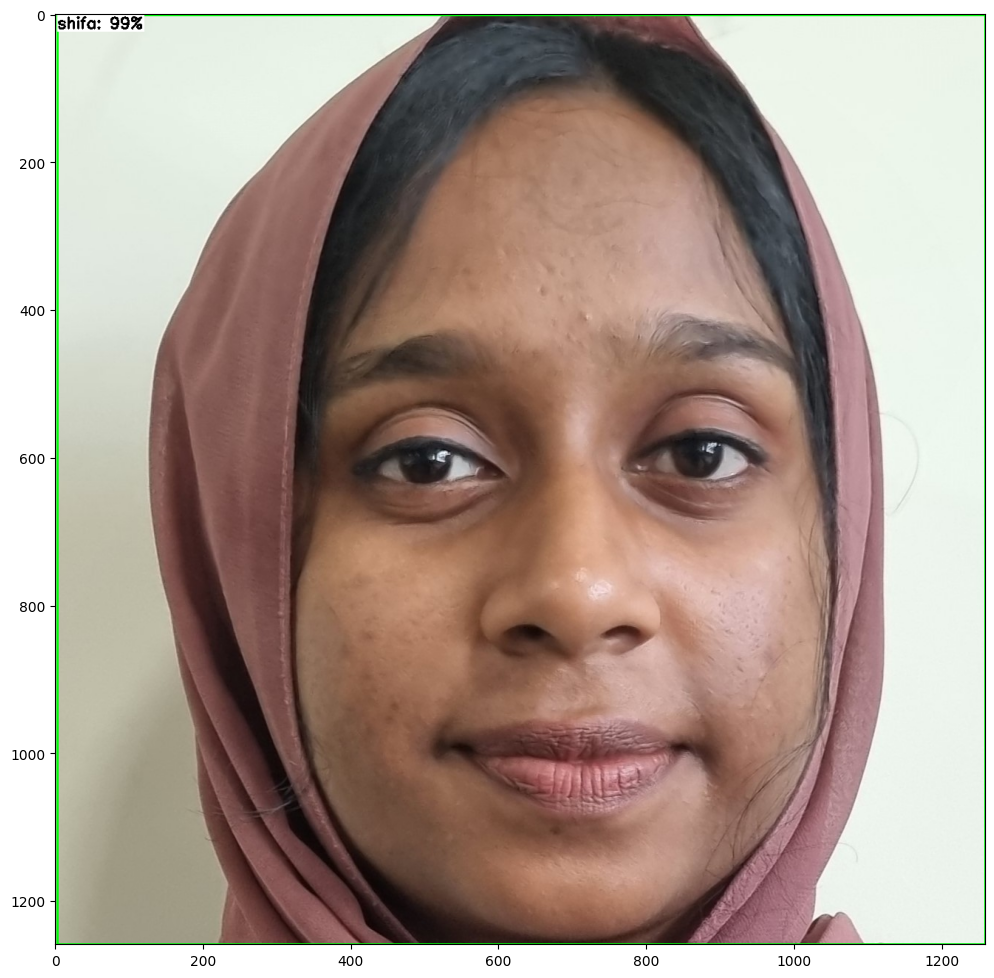

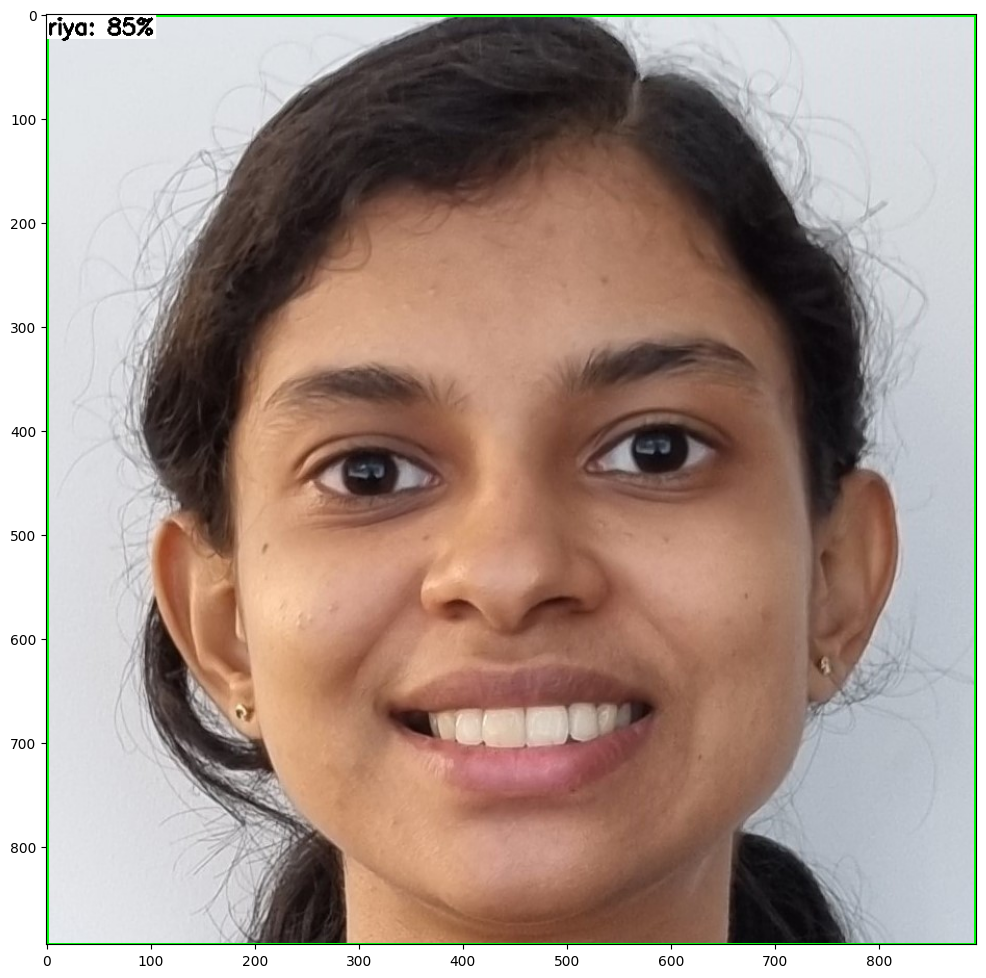

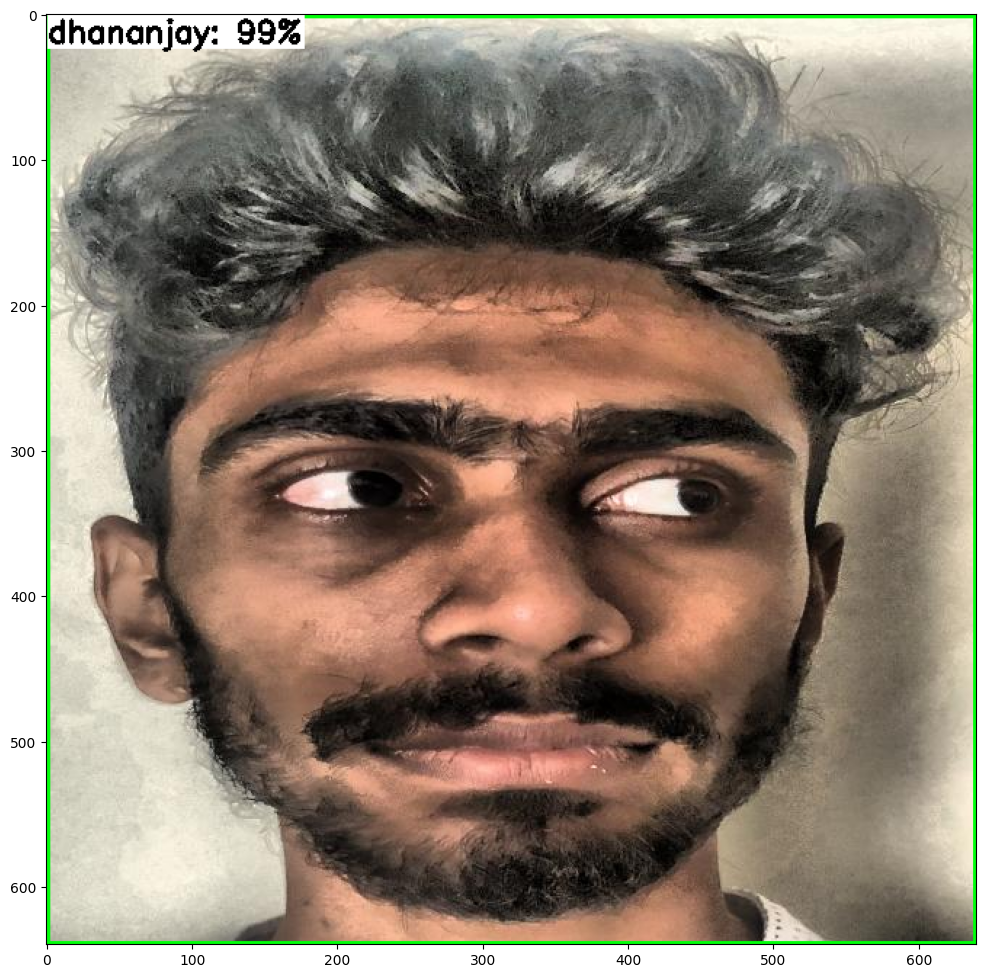

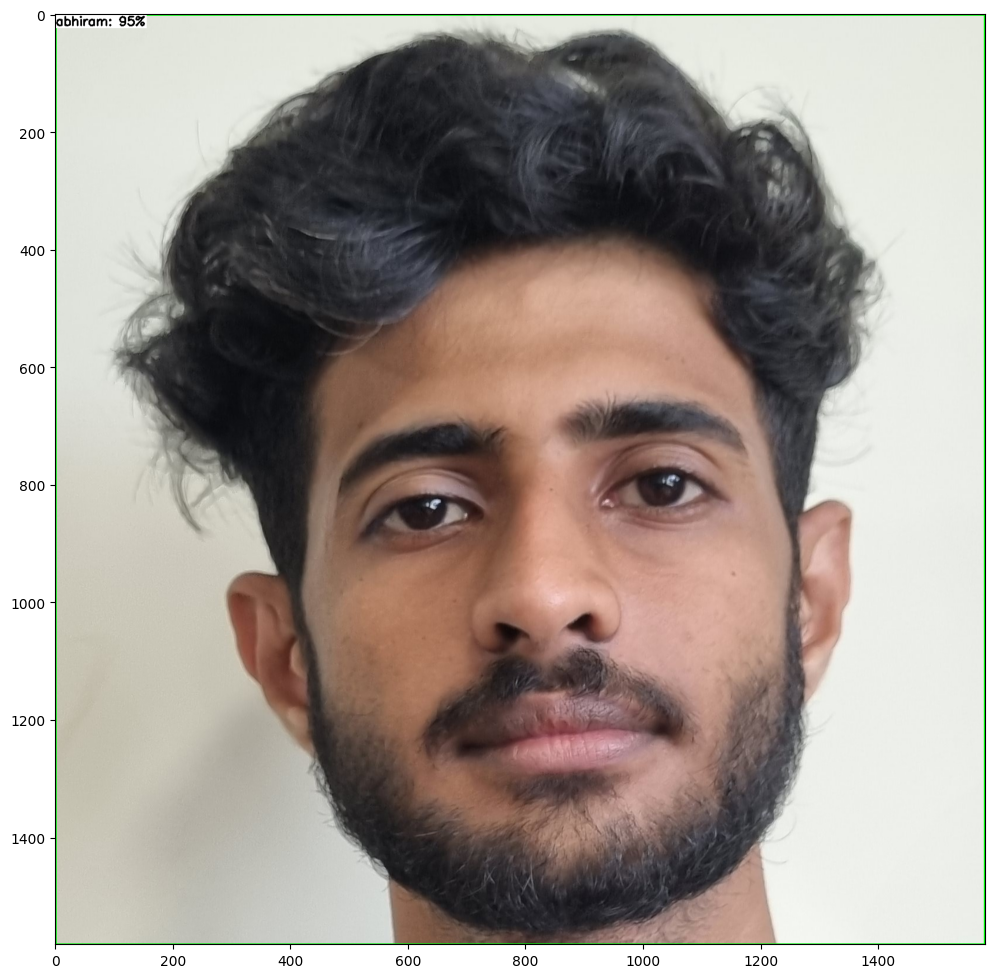

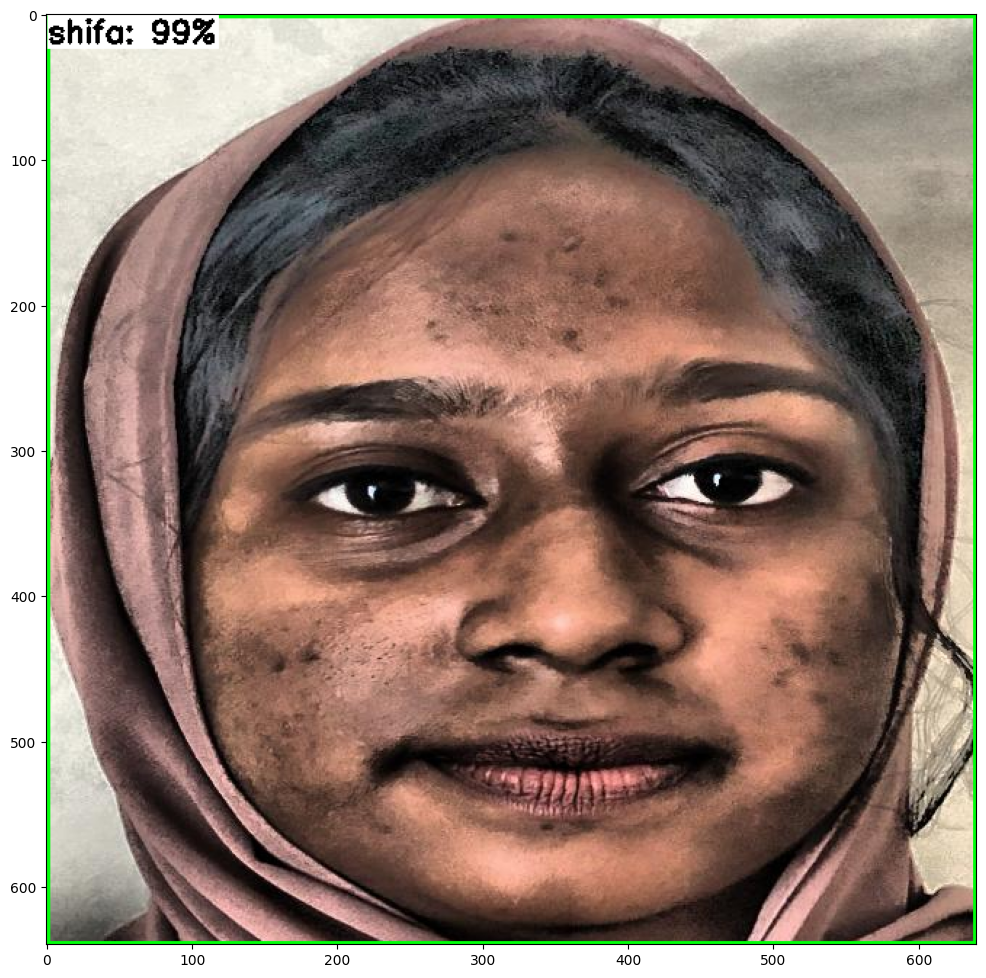

In [ ]:
# Set up variables for running user's model
PATH_TO_IMAGES='/content/gdrive/MyDrive/TFlowLite/test2/'   # Path to test images folder
PATH_TO_MODEL='/content/gdrive/MyDrive/TFlowLite/custom_model_lite/detect_metadata.tflite'#detect_quantization.tflite'   # Path to .tflite model file
PATH_TO_LABELS='/content/labelmap.txt'   # Path to labelmap.txt file
min_conf_threshold=0.5   # Confidence threshold (try changing this to 0.01 if you don't see any detection results)
images_to_test = 5   # Number of images to run adetection on

# Run inferencing function!
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test)